# Autoregression Performance FFN vs RNN
> 일반적으로 FFN은 입력의 순차적 종속성을 modeling하는데 한계가 있어 autoregressive task에서 취약점을 가지고 있다. 반면 GRU 등의 RNN계열의 모델은 hidden state를 통해 step window 이전의 sequence에 대한 summary 정보를 활용할 수 있으며 GRU의 경우 추가로 gating mechanism을 가지고 있어 보다 long term 의존성에 강건한 특성을 갖는 것으로 알려져 있다. 이를 몇 가지 경우에 적용하여 FFN과 GRU가 보이는 특성의 경향을 살펴보고 예외적인 경우 그리고 실제 적용 시 유용할 수 있는 Implication을 정리할 예정


## 1. 단순한 주기성을 갖는 Sinusoidal Input에 대한 비교 실험
- Sinusoidal time series의 경우 매우 단순한 주기성을 갖고 있기 때문에 long term dependency를 다룰 수 없는 FFN로도 충분한 성능을 얻을 수 있을 것으로 예상된다. 이를 확인하기 위해 1 cycle의 sin timeseries 입력을 생성하여 학습 시키고 prediction의 step을 증가시키며 발생되는 error의 누적의 영향, step window의 fractional length (e.g. 1 / 100일 경우 전체 입력 sample이 1000개일 때 10)의 변화에 따라 어떻게 영향을 받는 지 등을 실험해 보고자 한다. 

- 유사한 규모의 FFN / RNN (GRU)
  - FNN 3개의 Hidden Layer를 갖는 FFN를 구성 ReLU를 Activation으로 사용하여 아래와 같이 구성
  - FNN Model (1.5K parameters)
  
```
(net): Sequential(
  (0): Linear(in_features=10, out_features=20, bias=True)
  (1): ReLU()
  (2): Sequential(
    (0): Linear(in_features=20, out_features=20, bias=True)
    (1): ReLU()
  )
  (3): Sequential(
    (0): Linear(in_features=20, out_features=20, bias=True)
    (1): ReLU()
  )
  (4): Sequential(
    (0): Linear(in_features=20, out_features=20, bias=True)
    (1): ReLU()
  )
  (5): Linear(in_features=20, out_features=1, bias=True)
)
```
- RNN Model (1.8K parameters)
```
(model): Sequential(
    (0): GRU(1, 10, num_layers=3, batch_first=True)
    (1): SelectItem()
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): Linear(in_features=100, out_features=1, bias=True)
  )
```



In [34]:
from model import FFNAutoregressor, GRUAutoregress, SinusoidalTimeSeries
import pytorch_lightning as pl
from torch.utils import data



ffn_model = FFNAutoregressor.load_from_checkpoint('./model/ffn/model.ckpt')
gru_model = GRUAutoregress.load_from_checkpoint('./model/gru/model.ckpt')

def total_param(model: pl.LightningModule):
    return sum(p.numel() for p in model.parameters())

print(f"FFN parameters : {total_param(ffn_model)}")
print(f"RNN parameters : {total_param(gru_model)}")


dataset = SinusoidalTimeSeries(n_samples=4000)
trainer = pl.Trainer(accelerator="gpu")
trainer.test(ffn_model, dataloaders=data.DataLoader(dataset=dataset, batch_size=50))
trainer.test(gru_model, dataloaders=data.DataLoader(dataset=dataset, batch_size=50))


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


FFN parameters : 1501
RNN parameters : 1811


/home/fritzprix/miniconda3/envs/directml/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          6.121514888945967e-05
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          5.436805440695025e-05
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 5.436805440695025e-05}]

In [3]:
import utils
from model import SinusoidalTimeSeries
import train
import os
import torch

dataset = SinusoidalTimeSeries(n_samples=4000)
k_sweep = range(0, 500, 100)
device = torch.device('cuda')
batch_size = 50

reference = utils.predict_k_step_ahead(gru_model,dataset, batch_size=batch_size, device=device)
gru_preds = utils.sweep_kahead_pred(gru_model, dataset, k_sweep=k_sweep, device=device, batch_size=batch_size)
ffn_preds = utils.sweep_kahead_pred(ffn_model, dataset, k_sweep=k_sweep, device=device, batch_size=batch_size)



100%|██████████| 80/80 [00:05<00:00, 13.52it/s]


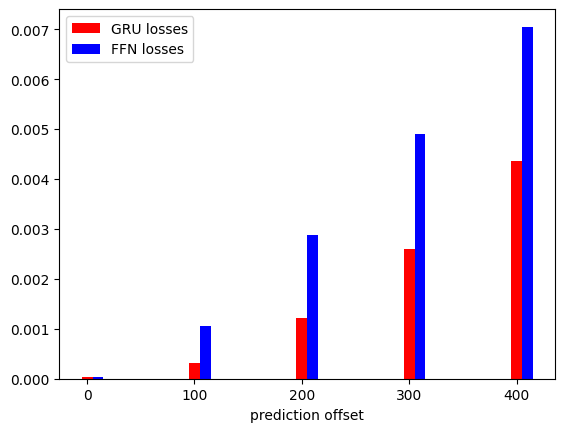

FFN Loss grow : 6.7044104618909675
GRU Loss grow : 13.511592166042556


In [33]:
import utils
from torch.nn import functional as F
from matplotlib import pyplot as plt
import numpy as np


gru_losses = [F.mse_loss(pred, reference).cpu().detach().item() for pred in gru_preds]
ffn_losses = [F.mse_loss(pred, reference).cpu().detach().item() for pred in ffn_preds]

x = np.array(range(0,500,100))
plt.bar(x, gru_losses, color='r', width=10, label='GRU losses')
plt.bar(x + 10, ffn_losses, color='b', width=10, label='FFN losses')
plt.xlabel('prediction offset')
plt.legend()
plt.show()

print(f"FFN Loss grow : {ffn_losses[-1] / ffn_losses[1]}")
print(f"GRU Loss grow : {gru_losses[-1] / gru_losses[1]}")


## N-Step Prediction Sweep Test

> 예측 Step의 길이를 100 ~ 400까지 증가 시키면서 성능의 열화가 발생하는 정도는 RNN이 FFN보다 우위의 성능을 보였다. 다만 prediction step이 커질 수록 GRU가 loss 열화가 더 가속화 되는 측면이 있었다. (Why?)

- Step 1 prediction의 결과 거의 0에 수렴하는 mse loss값을 보임
- prediction step을 증가 시킬 때 오차가 얼마나 증가하는지 테스트

In [6]:



preds = [predict_k_step(model, data_loader, i) for i in range(0,200,50)]


from matplotlib import pyplot as plt
from torch.nn import functional as F

def draw_comparison_chart(predicts:list, ref_idx: int = 0):
    predict_tensors = [torch.Tensor(pred) for pred in preds]
    fig = plt.figure()
    for idx, pred in enumerate(predict_tensors):
        loss = F.mse_loss(pred, predict_tensors[0])
        plt.plot(pred, label=f"{idx} loss {loss}")
    plt.legend()
    plt.show()
    
draw_comparison_chart(preds, 0)




 95%|█████████▍| 1888/1989 [00:10<00:03, 32.67it/s] 

: 

: 

- step 151에서 loss는 0.004로 step 1 대비 약 40배 증가
- 이처럼 step size 증가할 수록 error가 커짐

In [6]:
import pytorch_lightning as pl
import torch
from torch import nn

class SelectItem(nn.Module):
    def __init__(self, idx):
        super().__init__()
        self.idx = idx
        
    def forward(self, inputs) -> torch.Tensor:
        return inputs[self.idx]
        


class GRUAutoregress(pl.LightningModule):
    def __init__(self, n_steps, lr=1e-4):
        super().__init__()
        self.lr = lr
        self.model = nn.Sequential(
            nn.GRU(input_size=1, hidden_size=10, batch_first=True, num_layers=2),
            SelectItem(0),
            nn.Flatten(),
            nn.Linear(100, 1)
        )
        self.loss = nn.MSELoss()
        self.save_hyperparameters()
        
    def forward(self, X):
        assert(isinstance(X, torch.Tensor))
        X = X.unsqueeze(dim=2)
        return self.model(X)
    
    def training_step(self, batch, batch_idx) -> torch.Tensor:
        X, y = batch
        assert(isinstance(X, torch.Tensor))
        assert(isinstance(y, torch.Tensor))
        y_hat = self(X)
        loss = self.loss(y_hat, y)
        return loss
        
    def configure_optimizers(self) -> torch.optim.Optimizer:
        return torch.optim.Adam(self.parameters(), lr=self.lr)
    
    def validation_step(self, batch, batch_idx):
        X,y = batch
        assert(isinstance(X, torch.Tensor))
        assert(isinstance(y, torch.Tensor))
        y_hat = self(X)
        loss = nn.functional.mse_loss(y_hat, y)
        self.log("val_loss", loss)
        return {"val_loss": loss}
    
    def test_step(self, batch, batch_idx):
        X,y = batch
        assert(isinstance(X, torch.Tensor))
        assert(isinstance(y, torch.Tensor))
        y_hat = self(X)
        loss = nn.functional.mse_loss(y_hat, y)
        self.log("test_loss", loss)
        return {"test_loss": loss}

In [7]:
from pytorch_lightning import callbacks
from torch.utils import data
import os

ckpt_callback = callbacks.ModelCheckpoint('./model/gru', 
                                          filename='gru-autoregress-{val_loss:.2f}-{epoch}.ckpt',
                                          monitor='val_loss',
                                          mode='min',
                                          save_top_k=2)

model = GRUAutoregress(10)
train_dataset, val_dataset =  data.random_split(dataset, [0.9, 0.1])

train_loader = data.DataLoader(train_dataset, batch_size=10, num_workers=os.cpu_count())
val_loader = data.DataLoader(val_dataset, batch_size=10, num_workers=os.cpu_count())

trainer = pl.Trainer(accelerator="gpu", callbacks=[ckpt_callback], max_epochs=100)
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/fritzprix/miniconda3/envs/directml/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:604: UserWarning: Checkpoint directory /home/fritzprix/my_work/ml_note/labs/sin_sequence_model/model/gru exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 1.2 K 
1 | loss  | MSELoss    | 0     
-------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [8]:
import os
from torch.utils import data
import pytorch_lightning as pl
from tqdm import tqdm




model = GRUAutoregress.load_from_checkpoint('./model/gru/gru-autoregress-val_loss=0.00-epoch=99.ckpt-v2.ckpt')
model = model.to(torch.device("cpu"))

# result = trainer.test(model=model, dataloaders=data_loader)

def k_step_eval(model: pl.LightningModule, dataset: data.Dataset, k: int):
    pred = []
    model.eval()
    for X, y in tqdm(dataset):
        y_hat = y
        for step in range(k):
            assert(isinstance(X, torch.Tensor))
            assert(isinstance(y, torch.Tensor))
            y_hat = model(X.unsqueeze(0)).squeeze(0)
            X = torch.cat([X, y_hat])[1:]
        pred.append(y_hat.item())
    return pred
            
        

preds = [k_step_eval(model=model, dataset=dataset, k=k) for k in range(0, 200, 50)]

    

1990it [00:00, 263634.40it/s]           
1990it [00:55, 35.84it/s]                          
1990it [01:58, 16.84it/s]                          
1990it [02:58, 11.13it/s]                          


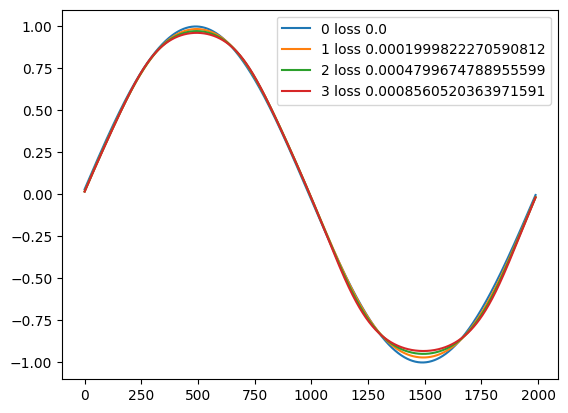

In [9]:
from matplotlib import pyplot as plt
from torch.nn import functional as F

def draw_comparison_chart(predicts:list, ref_idx: int = 0):
    predict_tensors = [torch.Tensor(pred) for pred in preds]
    fig = plt.figure()
    for idx, pred in enumerate(predict_tensors):
        loss = F.mse_loss(pred, predict_tensors[0])
        plt.plot(pred, label=f"{idx} loss {loss}")
    plt.legend()
    plt.show()
    
draw_comparison_chart(preds, 0)